We just did cropping till now.I tried to incorporate some of the preprocessing done i the class in this project and tried to see the results.

In [1]:
import pandas as pd

trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib.pyplot as plt

In [6]:
base_image_dir = os.path.join('train/')
df = pd.read_csv(os.path.join('trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,0,train/22266_left.jpeg
1,0,train/18078_left.jpeg
2,0,train/28993_right.jpeg
3,0,train/4642_left.jpeg
4,0,train/1808_left.jpeg
5,0,train/19500_right.jpeg
6,2,train/22523_left.jpeg
7,0,train/41281_right.jpeg
8,0,train/16652_right.jpeg
9,0,train/9243_right.jpeg


My first instinct was to look at 

In [7]:
def compute_edges(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (11, 11), 0)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobel_x = np.uint8(np.absolute(sobel_x))
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    sobel_y = np.uint8(np.absolute(sobel_y))
    edged = cv2.bitwise_or(sobel_x, sobel_y)
    return edged  
img=cv2.imread(df["path"][0])
img=compute_edges(img)

fisrt attempt find the edge of the circle representing the retina, then crop on the vertical tangent to the edge.

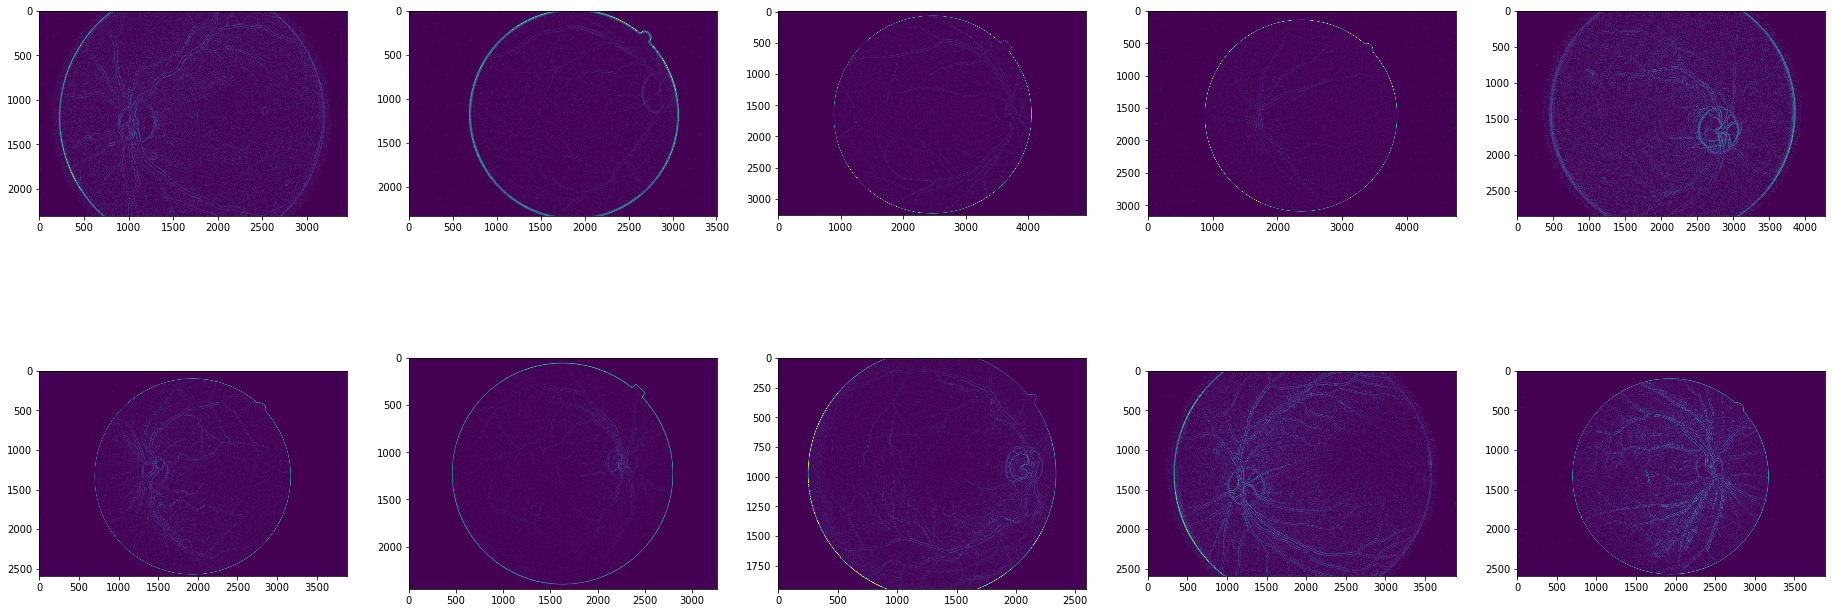

In [23]:
row=5
columns=5
index=1
fig=plt.figure(figsize=(32,32))

for i in random.sample(range(1,3500),10) :
    img=cv2.imread(df["path"][i])
    
    img=compute_edges(img)
                   
    fig.add_subplot(row,columns,index)
    plt.imshow(img)
    index+=1
plt.show()

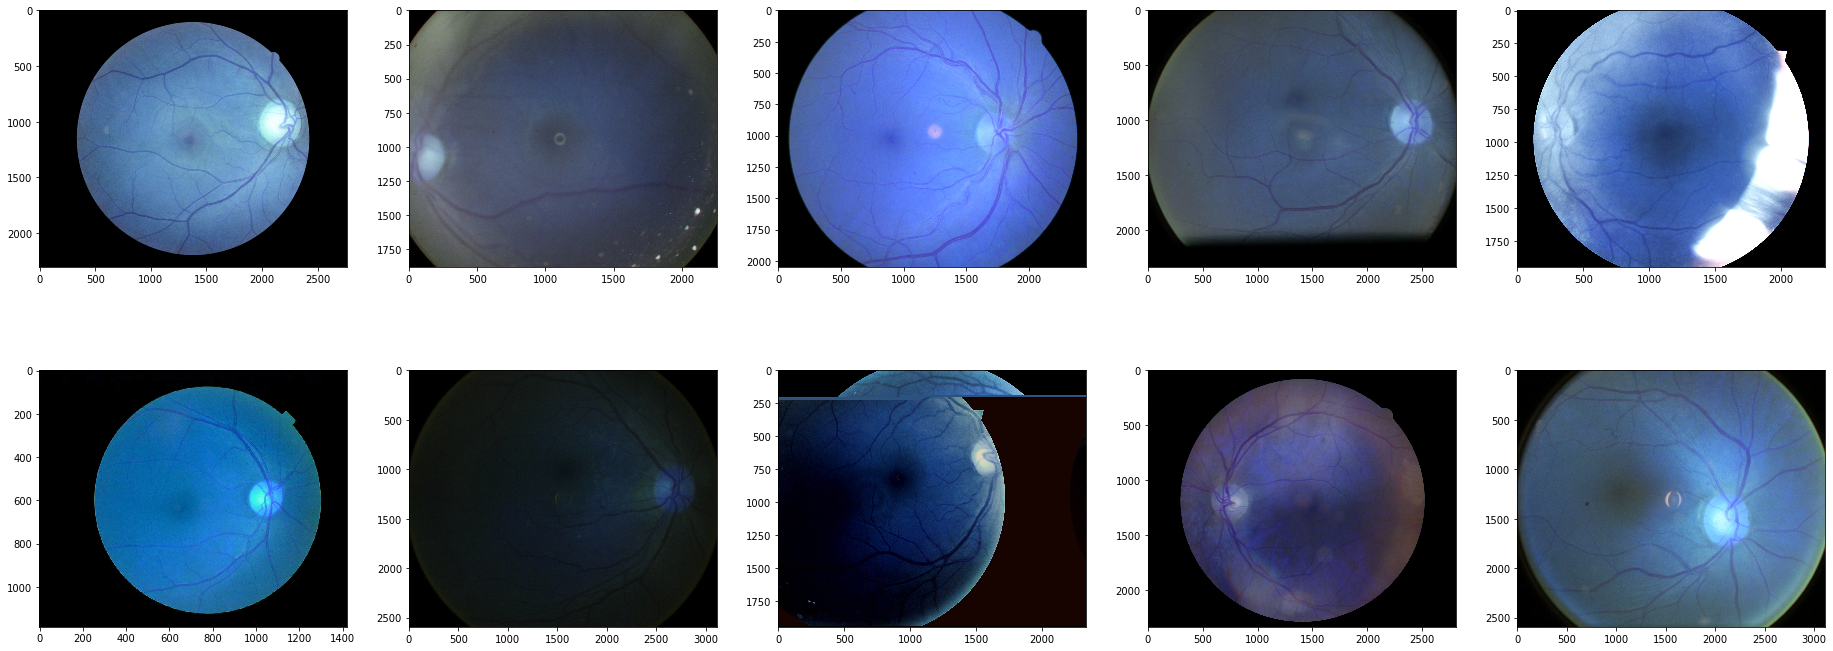

In [7]:
def crop_image_to_aspect(image, tar=1.2):
    # load image
    image_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_bw =image
    #cv2.imread(image)
    # compute aspect ratio
    h, w = image_bw.shape[0], image_bw.shape[1]
    sar = h / w if h > w else w / h
    if sar < tar:
        return image
    else:
        k = 0.5 * (1.0 - (tar / sar))
        if h > w:
            lb = int(k * h)
            ub = h - lb
            cropped = image[lb:ub, :, :]
        else:
            lb = int(k * w)
            ub = w - lb
            cropped = image[:, lb:ub, :]
        return cropped

row=5
columns=5
index=1
fig=plt.figure(figsize=(32,32))
index=1
for i in random.sample(range(1,3500),10) :
    img=cv2.imread(df["path"][i])
    
    img=crop_image_to_aspect(img)
                 
    fig.add_subplot(row,columns,index)
    plt.imshow(img) 
    index+=1
plt.show()


Next I tried looking at standardizing the brightnesses. Benjamin Graham's report suggests just subtracting the mean pixel value from each RGB channel, but I decided to do something a little fancier. First I converted each image to the HSV (Hue, Saturation, Value) color space and computed the mean value of V across all images in my sample. The value of V is a measure of the brightness of the image. I then computed the mean V per image. I then added the global V mean and subtracted the local V mean from each V, and converted it back to RGB.


In [9]:
def brighten_image_hsv(image, global_mean_v):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(image_hsv)
    mean_v = int(np.mean(v))
    v = v - mean_v + global_mean_v
    image_hsv = cv2.merge((h, s, v))
    image_bright = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return image_bright

vs = []
index=1
for i in random.sample(range(1,35000),4000):
    image = cv2.imread(df["path"][i])
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(image_hsv)
    vs.append(np.mean(v))
    if index%1000==0:
        print(index)
    index+=1
global_mean_v = int(np.mean(np.array(vs)))
 


1000
2000
3000
4000


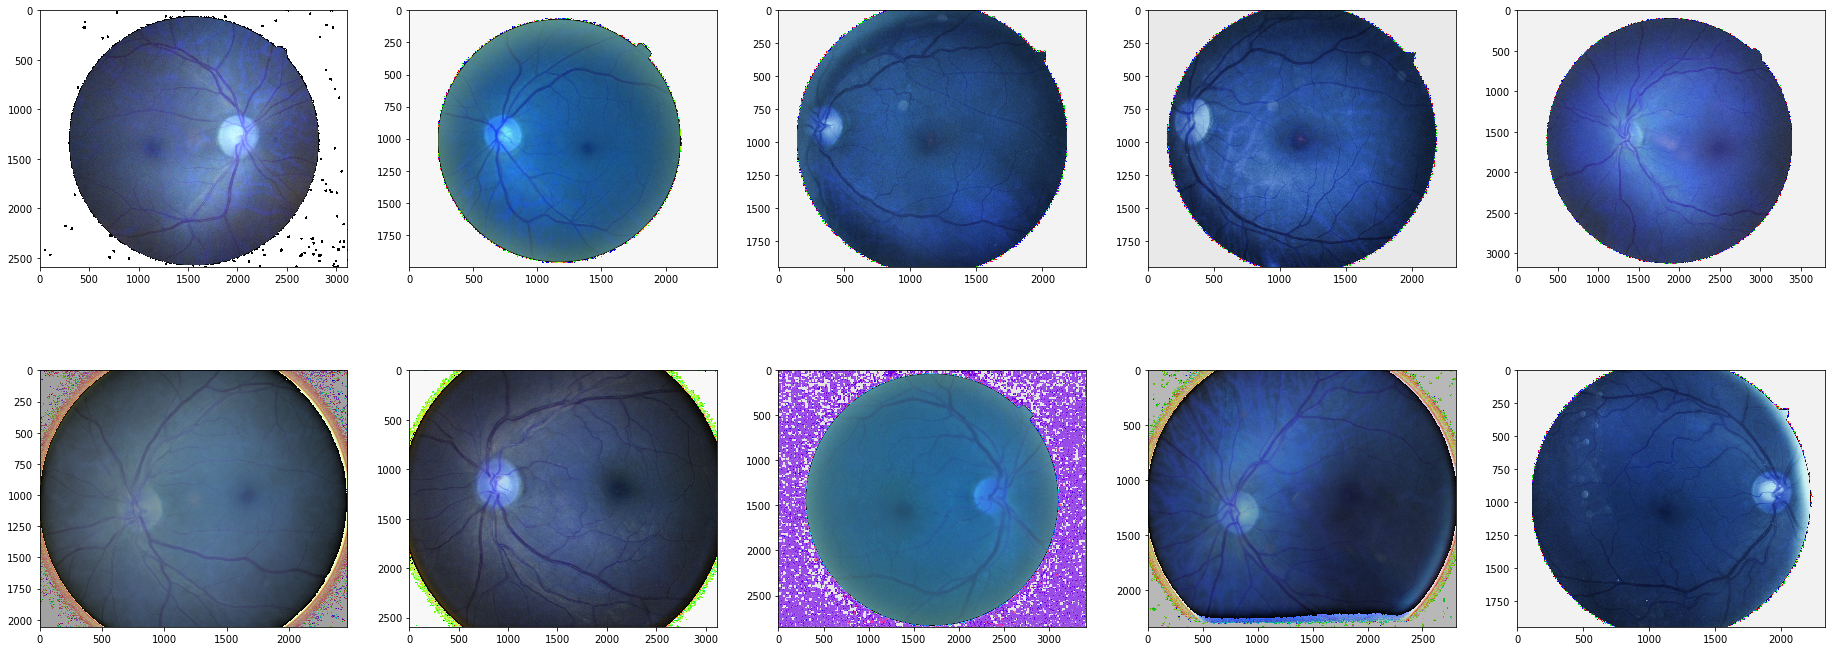

In [10]:
row=5
columns=5
index=1
fig=plt.figure(figsize=(32,32))
index=1
for i in random.sample(range(1,3500),10) :
    img=cv2.imread(df["path"][i])
    
    img=crop_image_to_aspect(img)
    img = brighten_image_hsv(img, global_mean_v)         
    fig.add_subplot(row,columns,index)
    plt.imshow(img) 
    index+=1
plt.show()